# Imports

In [ ]:
import pandas as pd
import numpy as np
import nltk

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.lang.id import Indonesian

from nltk.tokenize import word_tokenize
from nltk import pos_tag

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score

nltk.download('words')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')

extraStopWords = ['nya', 'yg', 'aja', 'deh', 'ny', 'dr', 'sy', 'ya','klo','sdh',
                  'drpd', 'udh', 'lah', 'ae', 'yak', 'yah', 'nih', 'udah',
                  'sampe','dah','tp','ga','gk','sih','gak','tdk','e','dgn','sm',
                  'tuh', 'utk', 'udh', 'lg', 'seh', 'na']

nlp = Indonesian()
# additional "stop words"
nlp.Defaults.stop_words.update(extraStopWords)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data Preparations

In [ ]:
np.random.seed(42)

In [ ]:
test_DF = pd.read_csv(r"test.csv")
test_DF

,text_a,label
0,jek dajal ga depok bang,no
1,detikcom untung depok masuk wilayah nya ridwan...,no
2,df dom jakarta depok yg gunain vc cabang nya c...,no
3,your2rl depok jkt,no
4,doakan indonesia selamat virus corona pkb depo...,yes
...,...,...
2795,ku tenang2 bae ku sih ya corona nya ga depok k...,no
2796,guru hati hati ya virus corona uda indonesia t...,yes
2797,4 terawan menyebut virus corona indonesia terd...,yes
2798,realffk buhari can t pronounce corona virus,no


In [ ]:
train_DF = pd.read_csv(r"train.csv")
train_DF = train_DF.drop(train_DF.columns[[0]], axis=1)
train_DF

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,no
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,e100ss gini buka informasi sejelas nya identit...,yes
3,neng solo wes ono terduga corona cobo neng ati...,no
4,midiahn nii akun gak takut takut nya isu coron...,no
...,...,...
21596,depok panas ga karuan kereta sampe pasming huj...,no
21597,oxfara arie kriting yg lebi goblo nya orang ke...,no
21598,virus corona menyaba depok cuci tangan makan n...,no
21599,mata sipit tinggal depok udah abis dah bahan c...,no


In [ ]:
used_words = []

# Remove empty text
test_DF["text_a"].dropna(inplace=True)
train_DF["text_a"].dropna(inplace=True)

# Do Tokenization and Stopwords filtering on both testDF and trainDF
def normalizeTokens(tokens):
  return " ".join(tokens)

def isTokenValid(token):
  return not(token.is_stop and not(token.is_punct)) and str(token)[0].isalpha()

def tokenizer(text):
  tokens = []
  for token in nlp(text):
    if isTokenValid(token):
      tokens.append(str(token))
      used_words.append(str(token))
  return tokens

test_DF["text_a"] = [normalizeTokens(tokenizer(row)) for row in test_DF["text_a"]]
train_DF["text_a"] = [normalizeTokens(tokenizer(row)) for row in train_DF["text_a"]]

# Do Encoding on testDF and trainDF label
Encoder = LabelEncoder()

train_Y = Encoder.fit_transform(train_DF["label"])
test_Y = Encoder.fit_transform(test_DF["label"])

In [ ]:
# TFIDF

# Do vectorization using TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)
tfidf_vect.fit(used_words)

train_X_Tfidf = tfidf_vect.transform(train_DF['text_a'])
test_X_Tfidf = tfidf_vect.transform(test_DF['text_a'])

# Model Training Shallow Machine Learning

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(train_X_Tfidf, train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(test_X_Tfidf)

# Model Evaluation Shallow Machine Learning

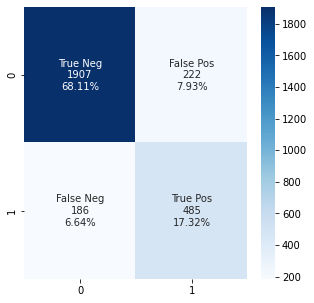

In [ ]:
# Using confusion matrix
plt.figure(figsize=(5,5))

cf_matrix = confusion_matrix(predictions_SVM, test_Y)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.show()

In [ ]:
# Using F1 Score
f1_value = f1_score(test_Y, predictions_SVM, average='macro')
print(f"F1 Score -> {f1_value*100:.2f}%")

F1 Score -> 80.36%


In [ ]:
# Using ROC AUC Value
roc_auc_value = roc_auc_score(test_Y, predictions_SVM)
print(f"ROC AUC Score -> {roc_auc_value*100:.2f}%")

ROC AUC Score -> 79.86%


In [ ]:
# Using accuracy score
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, test_Y)*100)

SVM Accuracy Score ->  85.42857142857143


# Non Contextual Word Embedding

##SETUP (PLEASE REDUCE PARTITION SIZE HERE IF YOUR NOTEBOOK KEEP CRASHING)

In [ ]:
# INSTALLATIONS

!pip install gensim==4.2.0
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# IMPORTS
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

print(gensim.__version__)

4.2.0


In [ ]:
# SETUPS
additional_stop_words = frozenset(extraStopWords)
stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)

# sengaja pake setengah dataset aja karena google collabnya ga kuad
n = len(train_DF)
partition = 0.5
partTrain = train_DF.loc[:n*partition]
corpus = partTrain['text_a'].values

# SET VECTORIZER
vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(corpus)
CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
WordsVocab=CountVectorizedData.columns

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# VERIFYING WORDS VOCAB
print("=====WORD VOCAB=====")
print(len(WordsVocab))
print(WordsVocab[0:20])

print("\n\n\n\n\n")

print("=====COUNT VECORIZER=====")
print(CountVectorizedData.shape)
CountVectorizedData.head()

=====WORD VOCAB=====
32306
Index(['02', '04', '05', '06', '08', '100gb', '106', '12', '13', '14', '15',
       '16030077', '19', '2012', '2020', '27', '2dpahe', '2e2006', '2e480p',
       '2e500mb'],
      dtype='object')






=====COUNT VECORIZER=====
(10801, 32306)


,02,04,05,06,08,100gb,106,12,13,14,...,وذ,ور,ول,وم,ون,ير,يط,يم,ين,يه
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Creating W2V Model
parsedTrainingData = [s.split(" ") for s in train_DF["text_a"].values]
w2v_model = gensim.models.Word2Vec(parsedTrainingData,
                                   window=5,
                                   min_count=2)


In [ ]:
# Converting text to vector form
def FunctionText2Vec(inpTextData, numberOfVector=100):
    # Converting the text to numeric data
    X = vectorizer.transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    W2Vec_Data=pd.DataFrame()
    
    # Looping through each row for the data
    for i in range(CountVecData.shape[0]):

        Sentence = np.zeros(numberOfVector)

        for word in WordsVocab[CountVecData.iloc[i,:]>=1]:
            if word in w2v_model.wv.key_to_index.keys():    
                Sentence=Sentence+w2v_model.wv[word]
        
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

def PrepareData(inpTextData, numberOfVector=100, targetColumn="label"):
  W2V_Data=FunctionText2Vec(inpTextData, numberOfVector)
  W2V_Data.shape
  W2V_Data.reset_index(inplace=True, drop=True)
  W2V_Data['result']=train_DF[targetColumn]

  targetColumn=W2V_Data.columns[-1]
  features=W2V_Data.columns[:-1]

  X=W2V_Data[features].values
  y=W2V_Data[targetColumn].values

  return(X,Encoder.fit_transform(y))

## Model Training Deep Learning

In [ ]:
# DEFINE MODEL

model = Sequential()
model.add(Dense(12, input_shape=(100,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
(X,y) = PrepareData(partTrain['text_a'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=428)
 
# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(7560, 100)
(7560,)
(3241, 100)
(3241,)


In [ ]:
model.fit(x=X_train, y=y_train, batch_size=100, epochs=20)

Epoch 1/20
76/76 [==============================] - 4s 3ms/step - loss: 0.9045 - accuracy: 0.6848
Epoch 2/20
76/76 [==============================] - 0s 3ms/step - loss: 0.5056 - accuracy: 0.7845
Epoch 3/20
76/76 [==============================] - 0s 3ms/step - loss: 0.4779 - accuracy: 0.7948
Epoch 4/20
76/76 [==============================] - 0s 3ms/step - loss: 0.4616 - accuracy: 0.8020
Epoch 5/20
76/76 [==============================] - 0s 3ms/step - loss: 0.4506 - accuracy: 0.8057
Epoch 6/20
76/76 [==============================] - 0s 3ms/step - loss: 0.4445 - accuracy: 0.8111
Epoch 7/20
76/76 [==============================] - 0s 3ms/step - loss: 0.4373 - accuracy: 0.8093
Epoch 8/20
76/76 [==============================] - 0s 3ms/step - loss: 0.4343 - accuracy: 0.8083
Epoch 9/20
76/76 [==============================] - 0s 3ms/step - loss: 0.4282 - accuracy: 0.8135
Epoch 10/20
76/76 [==============================] - 0s 3ms/step - loss: 0.4317 - accuracy: 0.8116
Epoch 11/20
76/76 [

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

102/102 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.8149
Accuracy: 81.49


## Model Evaluation Deep Learning

In [ ]:
(X_test,y_test) = PrepareData(test_DF['text_a'])
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

88/88 [==============================] - 0s 2ms/step - loss: 0.7697 - accuracy: 0.6250
Accuracy: 62.50


# Fine Tuning BERT

### Setup

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 31.8 MB/s 
     |████████████████████████████████| 120 kB 71.7 MB/s 
     |████████████████████████████████| 6.6 MB 60.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 27.7 MB/s 
     |████████████████████████████████| 212 kB 68.3 MB/s 
     |████████████████████████████████| 115 kB 73.0 MB/s 
     |████████████████████████████████| 127 kB 75.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 6.9 MB/s 


In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset,DatasetDict

model_name='cahya/bert-base-indonesian-522M'

dataset = DatasetDict()
dataset["train"] = load_dataset('csv', data_files={'train': 'train.csv'}).remove_columns("Unnamed: 0")["train"]
dataset["test"] = load_dataset('csv', data_files={'test': 'test.csv'})["test"]
tokenizer = AutoTokenizer.from_pretrained(model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7c3fab39b79bc5fd/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b248732c99a849ab/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
class BERTFineTunerMiddleware():
  @staticmethod
  def transform_labels(df: pd.DataFrame):
    label = df['label']
    if label == 'no':
      return {'labels': 0}
    if label == 'yes':
      return {'labels': 1}
    raise ValueError("Invalid label found in data frame")

  @staticmethod
  def tokenize_data(df: pd.DataFrame):
    return tokenizer(df['text_a'], padding='max_length', max_length=512, truncation=True)

In [ ]:
dataset = dataset.map(BERTFineTunerMiddleware.tokenize_data, batched=True)
dataset = dataset.map(BERTFineTunerMiddleware.transform_labels, remove_columns=['text_a','label'])

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/21601 [00:00<?, ?ex/s]

  0%|          | 0/2800 [00:00<?, ?ex/s]

### BERT Fine Tuning Training

In [ ]:
from transformers import TrainingArguments, AutoModelForSequenceClassification, Trainer

training_args = TrainingArguments("test_trainer", num_train_epochs=3)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-ba

In [ ]:
train_dataset = dataset['train'].shuffle(seed=10).select(range(21000))
eval_dataset = dataset['train'].shuffle(seed=10).select(range(21000, 21601))

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset, compute_metrics=compute_metrics
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 21000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7875


Step,Training Loss
500,0.474000
1000,0.408200
1500,0.404400
2000,0.432300
2500,0.459500
3000,0.422400
3500,0.408500
4000,0.373200
4500,0.373100
5000,0.388500


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json
Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2500
Configuration saved in test_trainer/checkpoint-2500/config.json
Model weights saved in test_trainer/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-30

TrainOutput(global_step=7875, training_loss=0.3941346018957713, metrics={'train_runtime': 5866.4062, 'train_samples_per_second': 10.739, 'train_steps_per_second': 1.342, 'total_flos': 1.657599648768e+16, 'train_loss': 0.3941346018957713, 'epoch': 3.0})

# Fine Tuned BERT Evaluation

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 601
  Batch size = 8


{'eval_loss': 0.33824968338012695,
 'eval_accuracy': 0.8768718801996672,
 'eval_runtime': 19.4881,
 'eval_samples_per_second': 30.839,
 'eval_steps_per_second': 3.9,
 'epoch': 3.0}